In [1]:
import pandas as pd 
import numpy as np 
from matplotlib_venn import venn2
import matplotlib.pyplot as plt 
import os 
from scipy.stats import norm 
from scipy.special import softmax
from scipy.stats import lognorm 

In [2]:
tshark_directory = os.path.join('.', 'traffictracer')
statistic_directory = ['WLAN_statistics', 'Meta_statistics'] 
ori_directory = ['WLAN', 'Meta'] 
port_directory = 'tshark_port' 
conn_directory = 'conn_in_out' 
evaluation_directory = 'evaluation'
data_date = '24-11-07'

activities = ['video', 'audio', 'upload', 'download', 'streaming', 'email']

meta_prefix = 'Meta-' 
wlan_prefix = 'WLAN-' 
conn_prefix = 'conn-in-out-' 

chrome_blue  = '#4285f4' 
chrome_red = '#ea4335' 
chrome_green = '#34a853' 
chrome_yellow = '#fbbc05' 

In [3]:
def mergeCsv(in_directory: str, out_directory: str, activities: list): 
    for i in range(len(activities)): 
        # step = 0 
        csv_list = [] 
        file_list = os.listdir(in_directory)
        for step in range(3): 
            df = pd.read_csv(os.path.join(in_directory, file_list[3 * i + step]), index_col=0) # conn_info的第一列是index列
            csv_list.append(df) 
        merge_df = pd.concat(csv_list, ignore_index=True) 
        merge_df.to_csv(os.path.join(out_directory, activities[i] + '.csv'))

In [4]:
def histLog(df: pd.DataFrame, out_path: str): 
    """ out_path直接包含文件名称
    """
    # 读取数据
    # df = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn', 'streaming.csv')) 
    b_fr = df['M Flows']
    a_fr = df['W Flows']

    # 对数变换
    b_fr_log = np.log1p(b_fr)
    a_fr_log = np.log1p(a_fr)

    # 设置 bin
    bins = np.linspace(min(b_fr_log.min(), a_fr_log.min()), max(b_fr_log.max(), a_fr_log.max()), 11)

    # 绘制直方图
    plt.figure(figsize=(4, 3))
    plt.rcParams['font.family'] = 'Microsoft YaHei'
    # M Flows
    hist1, bins1 = np.histogram(b_fr_log, bins=bins, density=True)
    plt.bar(bins1[:-1] - np.diff(bins1)*0.2, hist1, width=np.diff(bins1)*0.4, color=chrome_blue, edgecolor='black', label='Before', align='edge', alpha=0.8)
    shape1, loc1, scale1 = lognorm.fit(b_fr_log, floc=0)
    x1 = np.linspace(b_fr_log.min(), b_fr_log.max(), 100)
    p1 = lognorm.pdf(x1, shape1, loc1, scale1)
    plt.plot(x1, p1, 'blue', linewidth=2)

    # W Flows
    hist2, bins2 = np.histogram(a_fr_log, bins=bins, density=True)
    plt.bar(bins2[:-1] + np.diff(bins1)*0.2, hist2, width=np.diff(bins2)*0.4, color=chrome_red, edgecolor='black', label='After', align='edge', alpha=0.8)
    shape2, loc2, scale2 = lognorm.fit(a_fr_log, floc=0)
    x2 = np.linspace(a_fr_log.min(), a_fr_log.max(), 100)
    p2 = lognorm.pdf(x2, shape2, loc2, scale2)
    plt.plot(x2, p2, 'red', linewidth=2)

    # 添加标题和标签
    # plt.title('Histograms and Log-Normal Distribution Fits')
    plt.xlabel('Log Value')
    plt.ylabel('Density')
    plt.legend()

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    plt.savefig(out_path, format='pdf')
    # plt.show()

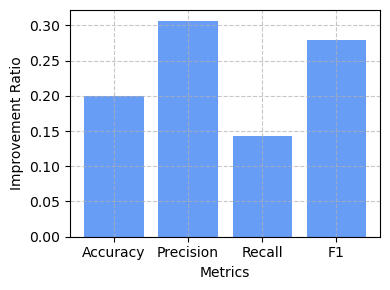

[0.19988642816581492, 0.30645161290322587, 0.14310051107325383, 0.2789373814041747]


In [11]:
# acuracy, precision, recall, f1
f3_performance = [0.2013 + 0.01, 0.0405, 0.2013, 0.0674] 
others_performance = [0.1761, 0.0310, 0.1761, 0.0527] 
ratio = [] 
for i in range(len(f3_performance)): 
    ratio.append((f3_performance[i] - others_performance[i]) / others_performance[i]) 

# 设置柱状图的位置
indices = np.arange(len(ratio))
labels = ['Accuracy', 'Precision', 'Recall', 'F1']

# 创建柱状图
plt.figure(figsize=(4, 3))
plt.bar(indices, ratio, color=chrome_blue, alpha=0.8)

# 添加标签和标题
plt.xlabel('Metrics')
plt.ylabel('Improvement Ratio')
# plt.title('Performance Ratio (F3 vs Others)')
plt.xticks(indices, labels)

plt.grid(True, linestyle='--', alpha=0.7)
# 显示图形
plt.tight_layout() 
plt.savefig(os.path.join(tshark_directory, evaluation_directory, 'model_evaluation', 'figs', 'improvement_ratio.pdf'), format='pdf')
# 显示图形
plt.show()
print(ratio)

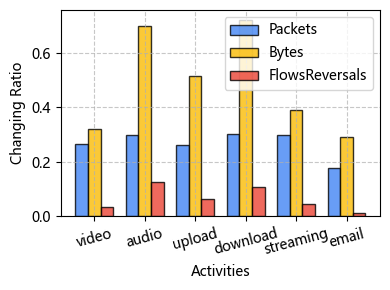

In [8]:
# 数据
average_packets_rate = [0.2631, 0.2969, 0.2606, 0.3005, 0.2985, 0.1765]
average_byte_rate = [0.3211, 0.6966, 0.5130, 0.7206, 0.3905, 0.2900]
average_flows_rate = [0.0320, 0.1249, 0.0642, 0.1082, 0.0435, 0.0115]

plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'
# 设置柱状图的位置
indices = np.arange(len(average_packets_rate))
width = 0.25

# 创建柱状图
plt.bar(indices, average_packets_rate, width=width, label='Packets', color=chrome_blue, edgecolor='black', align='center', alpha=0.8)
plt.bar(indices + width, average_byte_rate, width=width, label='Bytes', color=chrome_yellow, edgecolor='black', align='center', alpha=0.8)
plt.bar(indices + 2 * width, average_flows_rate, width=width, label='FlowsReversals', color=chrome_red, edgecolor='black', align='center', alpha=0.8)

# 添加标签和标题
plt.xlabel('Activities')
plt.ylabel('Changing Ratio')
# plt.title('Comparison of Average Rates')
plt.xticks(indices + width, [activities[i] for i in indices], rotation=15)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
# 显示图形
plt.tight_layout() 
# plt.savefig(os.path.join(tshark_directory, evaluation_directory, 'tt_similarity', 'figs', 'changing_rate_v4.pdf'), format='pdf')
plt.show()

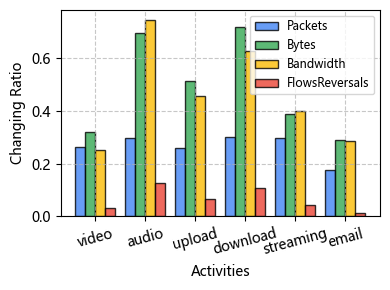

In [13]:
# 数据
average_packets_rate = [0.2631, 0.2969, 0.2606, 0.3005, 0.2985, 0.1765]
average_byte_rate = [0.3211, 0.6966, 0.5130, 0.7206, 0.3905, 0.2900]
average_flows_rate = [0.0320, 0.1249, 0.0642, 0.1082, 0.0435, 0.0115] 
average_bandwidth_rate = [0.2526, 0.7472, 0.4582, 0.6279, 0.4007, 0.2865]

plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'
# 设置柱状图的位置
indices = np.arange(len(average_packets_rate))
width = 0.2

# 创建柱状图
plt.bar(indices, average_packets_rate, width=width, label='Packets', color=chrome_blue, edgecolor='black', align='center', alpha=0.8) 
plt.bar(indices + width, average_byte_rate, width=width, label='Bytes', color=chrome_green, edgecolor='black', align='center', alpha=0.8) 
plt.bar(indices + 2 * width, average_bandwidth_rate, width=width, label='Bandwidth', color=chrome_yellow, edgecolor='black', align='center', alpha=0.8)
plt.bar(indices + 3 * width, average_flows_rate, width=width, label='FlowsReversals', color=chrome_red, edgecolor='black', align='center', alpha=0.8)

# 添加标签和标题
plt.xlabel('Activities')
plt.ylabel('Changing Ratio')
# plt.title('Comparison of Average Rates')
plt.xticks(indices + 1.5 * width, [activities[i] for i in indices], rotation=15)
plt.legend(fontsize='small')

plt.grid(True, linestyle='--', alpha=0.7)
# 显示图形
plt.tight_layout() 
plt.savefig(os.path.join(tshark_directory, evaluation_directory, 'tt_similarity', 'figs', 'changing_rate_improved_v2.pdf'), format='pdf')
plt.show()

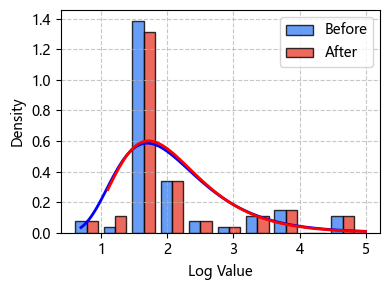

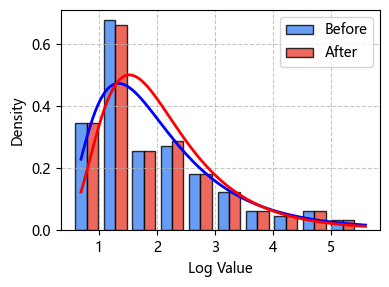

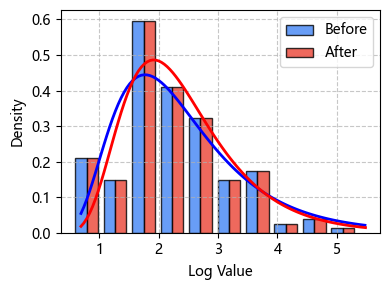

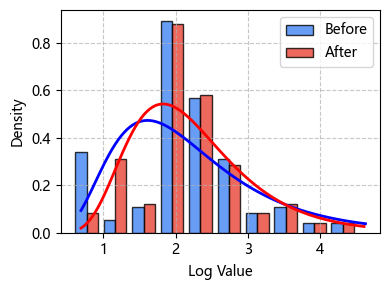

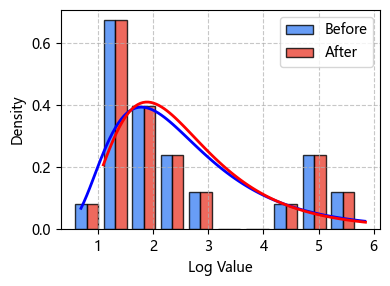

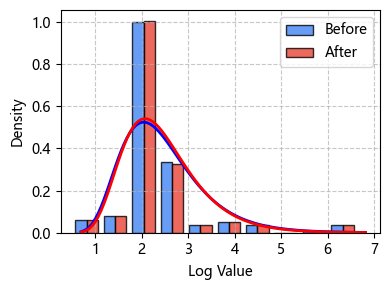

In [48]:
directory = os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn') 
# in_directory = os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'conn_sni') 
out_directory = os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn', 'figs') 

# mergeCsv(in_directory, out_directory, activities) 

for files in activities: 
    df = pd.read_csv(os.path.join(directory, files + '.csv')) 
    out_path = os.path.join(out_directory, files + '.pdf') 
    histLog(df, out_path) 

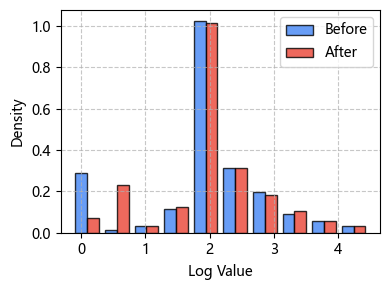

In [11]:
# 读取数据
df = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn', 'download.csv'))
b_fr = df['M Flows'] - 1
a_fr = df['W Flows'] - 1

# 对数变换
b_fr_log = np.log1p(b_fr)
a_fr_log = np.log1p(a_fr)

# 设置 bin
bins = np.linspace(min(b_fr_log.min(), a_fr_log.min()), max(b_fr_log.max(), a_fr_log.max()), 11)

# 绘制直方图
plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'
# M Flows
hist1, bins1 = np.histogram(b_fr_log, bins=bins, density=True)
plt.bar(bins1[:-1] - np.diff(bins1)*0.2, hist1, width=np.diff(bins1)*0.4, color=chrome_blue, edgecolor='black', label='Before', align='edge', alpha=0.8)
# shape1, loc1, scale1 = lognorm.fit(b_fr_log, floc=0)
x1 = np.linspace(b_fr_log.min(), b_fr_log.max(), 100)
# p1 = lognorm.pdf(x1, shape1, loc1, scale1)
# plt.plot(x1, p1, 'blue', linewidth=2)

# W Flows
hist2, bins2 = np.histogram(a_fr_log, bins=bins, density=True)
plt.bar(bins2[:-1] + np.diff(bins1)*0.2, hist2, width=np.diff(bins2)*0.4, color=chrome_red, edgecolor='black', label='After', align='edge', alpha=0.8)
# shape2, loc2, scale2 = lognorm.fit(a_fr_log, floc=0)
x2 = np.linspace(a_fr_log.min(), a_fr_log.max(), 100)
# p2 = lognorm.pdf(x2, shape2, loc2, scale2)
# plt.plot(x2, p2, 'red', linewidth=2)

# 添加标题和标签
# plt.title('Histograms and Log-Normal Distribution Fits')
plt.xlabel('Log Value')
plt.ylabel('Density')
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# plt.savefig('test.pdf', format='pdf')
plt.show()

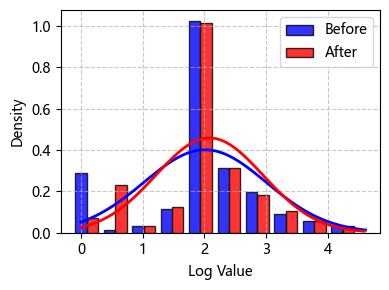

In [12]:

# 读取数据
df = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn', 'download.csv'))
b_fr = df['M Flows'] - 1
a_fr = df['W Flows'] - 1

# 对数变换
b_fr_log = np.log1p(b_fr)
a_fr_log = np.log1p(a_fr)

# 设置 bin
bins = np.linspace(min(b_fr_log.min(), a_fr_log.min()), max(b_fr_log.max(), a_fr_log.max()), 11)

# 绘制直方图
plt.figure(figsize=(4, 3))
plt.rcParams['font.family'] = 'Microsoft YaHei'

# M Flows
hist1, bins1 = np.histogram(b_fr_log, bins=bins, density=True)
plt.bar(bins1[:-1] - np.diff(bins1)*0.2, hist1, width=np.diff(bins1)*0.4, color='blue', edgecolor='black', label='Before', align='edge', alpha=0.8)
mu1, std1 = norm.fit(b_fr_log)
x1 = np.linspace(b_fr_log.min(), b_fr_log.max(), 100)
p1 = norm.pdf(x1, mu1, std1)
plt.plot(x1, p1, 'blue', linewidth=2)

# W Flows
hist2, bins2 = np.histogram(a_fr_log, bins=bins, density=True)
plt.bar(bins2[:-1] + np.diff(bins1)*0.2, hist2, width=np.diff(bins2)*0.4, color='red', edgecolor='black', label='After', align='edge', alpha=0.8)
mu2, std2 = norm.fit(a_fr_log)
x2 = np.linspace(a_fr_log.min(), a_fr_log.max(), 100)
p2 = norm.pdf(x2, mu2, std2)
plt.plot(x2, p2, 'red', linewidth=2)

# 添加标题和标签
plt.xlabel('Log Value')
plt.ylabel('Density')
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# plt.savefig('test.pdf', format='pdf')
plt.show()


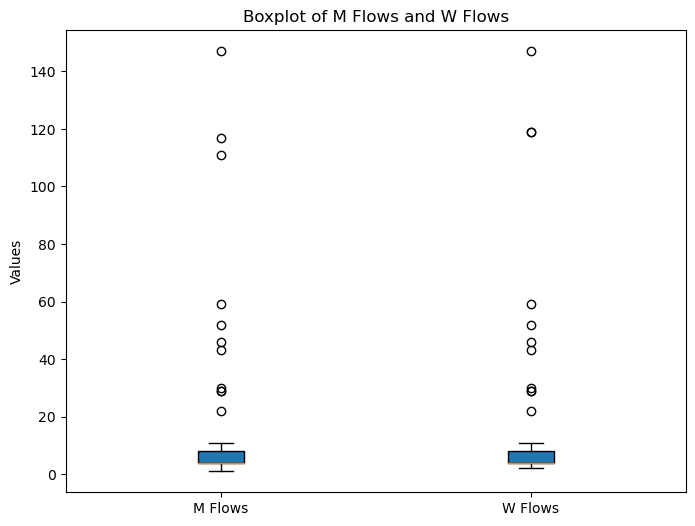

In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv(os.path.join(tshark_directory, evaluation_directory, 'tt_stream_distribution', 'merge_conn', 'video.csv'))
b_fr = df['M Flows']
a_fr = df['W Flows']

# 绘制箱线图
plt.figure(figsize=(8, 6))
plt.boxplot([b_fr, a_fr], labels=['M Flows', 'W Flows'], patch_artist=True)

# 添加标题和标签
plt.title('Boxplot of M Flows and W Flows')
plt.ylabel('Values')

plt.show()
